## Initialisation time series

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 19660
INFO:tensorflow:Using local port 19137
INFO:tensorflow:Using local port 15506
INFO:tensorflow:Using local port 19822
INFO:tensorflow:Using local port 19711
INFO:tensorflow:Using local port 21059
INFO:tensorflow:Using local port 15439
INFO:tensorflow:Using local port 21896
INFO:tensorflow:Using local port 20223
INFO:tensorflow:Using local port 19691
python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([])
	inp = keras.layers.Input(batch_shape= (batch_size, X.shape[1], X.shape[2]),name="input")
	rnn = keras.layers.LSTM(neurons, return_sequences=True, stateful=False,name="RNN")(inp)
	dens = keras.layers.TimeDistributed(keras.layers.Dense(1,name="dense"))(rnn)
	model = keras.models.Model(inputs=[inp],outputs=[dens])
	model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
	model.summary()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


## Evaluation

Fonction de détermination de l'erreur absolue en pourcentage

Combien de \% d'écart en moyenne entre la donnée prédite et la donnée mesurée

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

## Importation des données

Colonnes importées : 2e, 3e et 8e colonnes

2e colonne : Temps
3e colonne : identifiant Antenne
7e colonne : Quantité de données

In [4]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [5]:
dataset = dataframe.values

In [6]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

## Sélection des données

Isolation d'une antenne (ID : 39)

Convertion du temps en heures

In [7]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

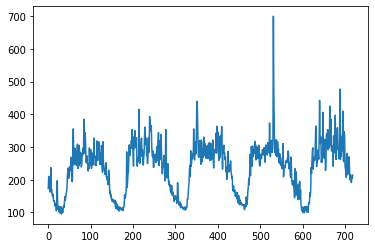

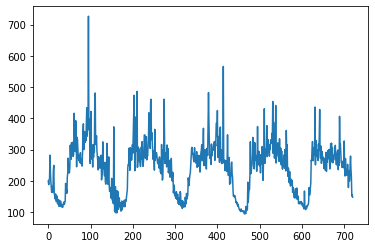

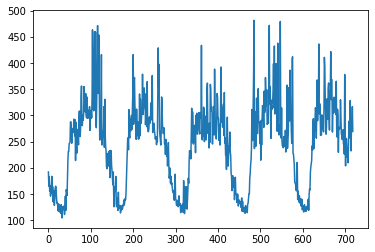

In [8]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

## Découpage du jeu de données

Définition d'un jeu d'entrainement et d'un jeu de test

Mise à l'échelle des données sur l'intervalle \[0,1\]

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


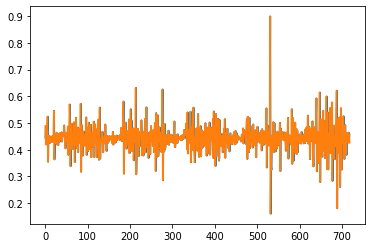

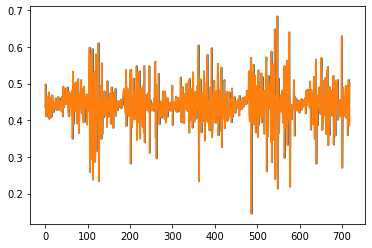

In [9]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [10]:
test_scaled[0]

raw_values[-int(l/3)-0]

191.95605

## Entrainement

In [440]:
hunits = 1

lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

(1439, 1, 1)
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(1, 1, 1)]               0         
_________________________________________________________________
RNN (LSTM)                   (1, 1, 1)                 12        
_________________________________________________________________
time_distributed_10 (TimeDis (1, 1, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


array([[[0.44282812]],

       [[0.44102472]],

       [[0.4438079 ]],

       ...,

       [[0.44395947]],

       [[0.44585598]],

       [[0.44267443]]], dtype=float32)

## Prédiction

Prédiction de la donnée et établissement d'un jeu de données prédite.

In [441]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
#	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
#	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
#	expected = raw_values[len(train) + i + 1]

#	predictions.append(yhat)

#for i in range(len(test_scaled)):
	print('hour=%d, Origin=%f, Predicted=%f, Expected=%f' % ((i+1)/6, X, yhat, y))

hour=0, Origin=0.435522, Predicted=0.443157, Expected=0.497889
hour=0, Origin=0.497889, Predicted=0.440682, Expected=0.410709
hour=0, Origin=0.410709, Predicted=0.444146, Expected=0.465723
hour=0, Origin=0.465723, Predicted=0.441956, Expected=0.410070
hour=0, Origin=0.410070, Predicted=0.444172, Expected=0.456710
hour=1, Origin=0.456710, Predicted=0.442314, Expected=0.419286
hour=1, Origin=0.419286, Predicted=0.443804, Expected=0.465536
hour=1, Origin=0.465536, Predicted=0.441963, Expected=0.435800
hour=1, Origin=0.435800, Predicted=0.443146, Expected=0.476196
hour=1, Origin=0.476196, Predicted=0.441540, Expected=0.403361
hour=1, Origin=0.403361, Predicted=0.444440, Expected=0.460324
hour=2, Origin=0.460324, Predicted=0.442170, Expected=0.408193
hour=2, Origin=0.408193, Predicted=0.444247, Expected=0.451864
hour=2, Origin=0.451864, Predicted=0.442506, Expected=0.462336
hour=2, Origin=0.462336, Predicted=0.442090, Expected=0.408626
hour=2, Origin=0.408626, Predicted=0.444230, Expected=0

hour=22, Origin=0.494921, Predicted=0.440799, Expected=0.348621
hour=22, Origin=0.348621, Predicted=0.446634, Expected=0.555984
hour=22, Origin=0.555984, Predicted=0.438394, Expected=0.361378
hour=22, Origin=0.361378, Predicted=0.446122, Expected=0.415856
hour=22, Origin=0.415856, Predicted=0.443941, Expected=0.432810
hour=23, Origin=0.432810, Predicted=0.443265, Expected=0.407275
hour=23, Origin=0.407275, Predicted=0.444284, Expected=0.439432
hour=23, Origin=0.439432, Predicted=0.443001, Expected=0.479240
hour=23, Origin=0.479240, Predicted=0.441420, Expected=0.413456
hour=23, Origin=0.413456, Predicted=0.444037, Expected=0.463676
hour=23, Origin=0.463676, Predicted=0.442037, Expected=0.456752
hour=24, Origin=0.456752, Predicted=0.442312, Expected=0.443176
hour=24, Origin=0.443176, Predicted=0.442852, Expected=0.447832
hour=24, Origin=0.447832, Predicted=0.442667, Expected=0.381495
hour=24, Origin=0.381495, Predicted=0.445315, Expected=0.507282
hour=24, Origin=0.507282, Predicted=0.44

hour=44, Origin=0.434661, Predicted=0.443191, Expected=0.430455
hour=44, Origin=0.430455, Predicted=0.443359, Expected=0.472062
hour=44, Origin=0.472062, Predicted=0.441704, Expected=0.527706
hour=44, Origin=0.527706, Predicted=0.439505, Expected=0.434939
hour=45, Origin=0.434939, Predicted=0.443180, Expected=0.388432
hour=45, Origin=0.388432, Predicted=0.445037, Expected=0.434325
hour=45, Origin=0.434325, Predicted=0.443204, Expected=0.431964
hour=45, Origin=0.431964, Predicted=0.443298, Expected=0.451883
hour=45, Origin=0.451883, Predicted=0.442506, Expected=0.448993
hour=45, Origin=0.448993, Predicted=0.442621, Expected=0.406302
hour=46, Origin=0.406302, Predicted=0.444322, Expected=0.449893
hour=46, Origin=0.449893, Predicted=0.442585, Expected=0.413211
hour=46, Origin=0.413211, Predicted=0.444046, Expected=0.478764
hour=46, Origin=0.478764, Predicted=0.441439, Expected=0.428201
hour=46, Origin=0.428201, Predicted=0.443448, Expected=0.419881
hour=46, Origin=0.419881, Predicted=0.44

hour=66, Origin=0.484972, Predicted=0.441193, Expected=0.508409
hour=66, Origin=0.508409, Predicted=0.440266, Expected=0.435237
hour=66, Origin=0.435237, Predicted=0.443168, Expected=0.394001
hour=67, Origin=0.394001, Predicted=0.444814, Expected=0.444281
hour=67, Origin=0.444281, Predicted=0.442808, Expected=0.392586
hour=67, Origin=0.392586, Predicted=0.444871, Expected=0.479303
hour=67, Origin=0.479303, Predicted=0.441417, Expected=0.445235
hour=67, Origin=0.445235, Predicted=0.442770, Expected=0.395610
hour=67, Origin=0.395610, Predicted=0.444750, Expected=0.514935
hour=68, Origin=0.514935, Predicted=0.440008, Expected=0.554631
hour=68, Origin=0.554631, Predicted=0.438447, Expected=0.358364
hour=68, Origin=0.358364, Predicted=0.446243, Expected=0.400355
hour=68, Origin=0.400355, Predicted=0.444560, Expected=0.460989
hour=68, Origin=0.460989, Predicted=0.442144, Expected=0.415188
hour=68, Origin=0.415188, Predicted=0.443968, Expected=0.484066
hour=69, Origin=0.484066, Predicted=0.44

hour=88, Origin=0.466214, Predicted=0.441936, Expected=0.437397
hour=88, Origin=0.437397, Predicted=0.443082, Expected=0.474688
hour=88, Origin=0.474688, Predicted=0.441600, Expected=0.503406
hour=88, Origin=0.503406, Predicted=0.440464, Expected=0.341011
hour=89, Origin=0.341011, Predicted=0.446940, Expected=0.588097
hour=89, Origin=0.588097, Predicted=0.437137, Expected=0.285061
hour=89, Origin=0.285061, Predicted=0.449197, Expected=0.457996
hour=89, Origin=0.457996, Predicted=0.442263, Expected=0.438033
hour=89, Origin=0.438033, Predicted=0.443057, Expected=0.552682
hour=89, Origin=0.552682, Predicted=0.438523, Expected=0.384192
hour=90, Origin=0.384192, Predicted=0.445207, Expected=0.346106
hour=90, Origin=0.346106, Predicted=0.446736, Expected=0.444260
hour=90, Origin=0.444260, Predicted=0.442809, Expected=0.648545
hour=90, Origin=0.648545, Predicted=0.434786, Expected=0.238804
hour=90, Origin=0.238804, Predicted=0.451071, Expected=0.445536
hour=90, Origin=0.445536, Predicted=0.44

hour=110, Origin=0.414609, Predicted=0.443991, Expected=0.425398
hour=110, Origin=0.425398, Predicted=0.443560, Expected=0.515264
hour=110, Origin=0.515264, Predicted=0.439996, Expected=0.456925
hour=110, Origin=0.456925, Predicted=0.442305, Expected=0.362632
hour=110, Origin=0.362632, Predicted=0.446072, Expected=0.415085
hour=110, Origin=0.415085, Predicted=0.443972, Expected=0.534601
hour=111, Origin=0.534601, Predicted=0.439234, Expected=0.433465
hour=111, Origin=0.433465, Predicted=0.443239, Expected=0.546272
hour=111, Origin=0.546272, Predicted=0.438775, Expected=0.331952
hour=111, Origin=0.331952, Predicted=0.447305, Expected=0.491251
hour=111, Origin=0.491251, Predicted=0.440944, Expected=0.404885
hour=111, Origin=0.404885, Predicted=0.444379, Expected=0.359322
hour=112, Origin=0.359322, Predicted=0.446204, Expected=0.490164
hour=112, Origin=0.490164, Predicted=0.440987, Expected=0.473168
hour=112, Origin=0.473168, Predicted=0.441660, Expected=0.412480
hour=112, Origin=0.412480

Generate proper data with 1 data shift

In [442]:
# walk-forward validation on the training data
X_train = list()
y_train = list()

X_train.append(train_scaled[len(train_scaled)-1, 0:-1][0])
y_train.append(train_scaled[0, 0:-1][0])

for i in range(1,len(train_scaled)):
	# make one-step forecast
    X_train.append(train_scaled[i-1, 0:-1][0])
    y_train.append(train_scaled[i, 0:-1][0])
    
for i in range(len(train_scaled)):
	print('X_train=%f, y_train=%f' % (X_train[i], y_train[i]))

X_train=0.447637, y_train=0.443775
X_train=0.443775, y_train=0.489216
X_train=0.489216, y_train=0.419188
X_train=0.419188, y_train=0.433686
X_train=0.433686, y_train=0.419556
X_train=0.419556, y_train=0.454473
X_train=0.454473, y_train=0.524359
X_train=0.524359, y_train=0.354362
X_train=0.354362, y_train=0.452008
X_train=0.452008, y_train=0.424531
X_train=0.424531, y_train=0.437975
X_train=0.437975, y_train=0.451010
X_train=0.451010, y_train=0.425360
X_train=0.425360, y_train=0.434361
X_train=0.434361, y_train=0.446799
X_train=0.446799, y_train=0.438043
X_train=0.438043, y_train=0.429177
X_train=0.429177, y_train=0.451676
X_train=0.451676, y_train=0.430366
X_train=0.430366, y_train=0.432408
X_train=0.432408, y_train=0.453686
X_train=0.453686, y_train=0.546044
X_train=0.546044, y_train=0.363016
X_train=0.363016, y_train=0.417084
X_train=0.417084, y_train=0.454731
X_train=0.454731, y_train=0.424067
X_train=0.424067, y_train=0.442697
X_train=0.442697, y_train=0.464402
X_train=0.464402, y_

In [443]:
# walk-forward validation on the testing data
X_test = list()
y_test = list()

X_test.append(test_scaled[len(test_scaled)-1, 0:-1][0])
y_test.append(test_scaled[0, 0:-1][0])

for i in range(1,len(test_scaled)):
	# make one-step forecast
    X_test.append(test_scaled[i-1, 0:-1][0])
    y_test.append(test_scaled[i, 0:-1][0])
    
for i in range(len(test_scaled)):
	print('X_test=%f, y_test=%f' % (X_test[i], y_test[i]))

X_test=0.502387, y_test=0.435522
X_test=0.435522, y_test=0.497889
X_test=0.497889, y_test=0.410709
X_test=0.410709, y_test=0.465723
X_test=0.465723, y_test=0.410070
X_test=0.410070, y_test=0.456710
X_test=0.456710, y_test=0.419286
X_test=0.419286, y_test=0.465536
X_test=0.465536, y_test=0.435800
X_test=0.435800, y_test=0.476196
X_test=0.476196, y_test=0.403361
X_test=0.403361, y_test=0.460324
X_test=0.460324, y_test=0.408193
X_test=0.408193, y_test=0.451864
X_test=0.451864, y_test=0.462336
X_test=0.462336, y_test=0.408626
X_test=0.408626, y_test=0.458388
X_test=0.458388, y_test=0.468078
X_test=0.468078, y_test=0.449678
X_test=0.449678, y_test=0.441211
X_test=0.441211, y_test=0.421694
X_test=0.421694, y_test=0.429245
X_test=0.429245, y_test=0.444961
X_test=0.444961, y_test=0.433267
X_test=0.433267, y_test=0.434761
X_test=0.434761, y_test=0.460047
X_test=0.460047, y_test=0.441348
X_test=0.441348, y_test=0.427690
X_test=0.427690, y_test=0.455646
X_test=0.455646, y_test=0.439447
X_test=0.4

X_test=0.428494, y_test=0.452968
X_test=0.452968, y_test=0.435931
X_test=0.435931, y_test=0.442267
X_test=0.442267, y_test=0.454961
X_test=0.454961, y_test=0.440055
X_test=0.440055, y_test=0.440561
X_test=0.440561, y_test=0.460530
X_test=0.460530, y_test=0.450901
X_test=0.450901, y_test=0.418163
X_test=0.418163, y_test=0.480694
X_test=0.480694, y_test=0.456578
X_test=0.456578, y_test=0.441573
X_test=0.441573, y_test=0.484161
X_test=0.484161, y_test=0.457099
X_test=0.457099, y_test=0.450744
X_test=0.450744, y_test=0.451478
X_test=0.451478, y_test=0.477777
X_test=0.477777, y_test=0.434066
X_test=0.434066, y_test=0.506115
X_test=0.506115, y_test=0.454850
X_test=0.454850, y_test=0.373795
X_test=0.373795, y_test=0.482403
X_test=0.482403, y_test=0.451181
X_test=0.451181, y_test=0.466476
X_test=0.466476, y_test=0.470477
X_test=0.470477, y_test=0.428537
X_test=0.428537, y_test=0.388089
X_test=0.388089, y_test=0.504379
X_test=0.504379, y_test=0.518990
X_test=0.518990, y_test=0.348817
X_test=0.3

## LSTM model

Our goal is to create a LSTM model to predict y_train using the time series X_train

In [444]:
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)
model1 = lstm_model
model1.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(1, 1, 1)]               0         
_________________________________________________________________
RNN (LSTM)                   (1, 1, 1)                 12        
_________________________________________________________________
time_distributed_10 (TimeDis (1, 1, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [445]:
w = np.zeros(y_test_array.shape[:2])
D=1
w[D:] = 1 
w_train = w

In [446]:
from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_test_array, y_test_array, 
                   batch_size=1,
                   epochs=10, 
                   verbose=False,
                   validation_split=0.05,
                   shuffle=False)
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

Time took 0.2 min


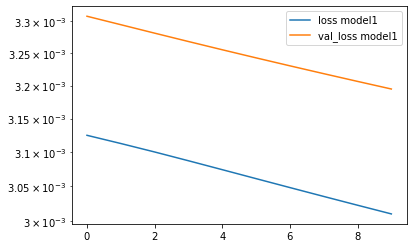

In [447]:
labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show()

In [448]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
print(warr)
print("\n")
print(uarr)
print("\n")
print(barr)

print(model1.layers[2].get_weights())
warr.shape,uarr.shape,barr.shape

[[-0.80634767  0.06758153  0.1901507  -0.57651734]]


[[-0.5552     -0.80215526  0.21732922 -0.03267891]]


[ 0.40350956  1.         -0.4774223   0.42344746]
[array([[-0.9467103]], dtype=float32), array([0.34821823], dtype=float32)]


((1, 4), (1, 4), (4,))

In [449]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    print(s_t)
    hunit = uarr.shape[0]
    print(s_t[:,:hunit])
    i  = sigmoid(s_t[:,:hunit])
    print(i)
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    print(s_t[:,2*hunit:3*hunit])
    print(_c)
    o  = sigmoid(s_t[:,3*hunit:])
    print(i*_c)
    print("\n")
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

In [450]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

In [451]:
xs  = X_test_array
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

[[-0.00158916  1.0339521  -0.38189303  0.13381255]]
[[-0.00158916]]
[[0.49960271]]
[[-0.38189303]]
[[-0.36435033]]
[[-0.18203041]]


[[ 0.10564714  1.10647002 -0.41547915  0.17549977]]
[[0.10564714]]
[[0.52638725]]
[[-0.41547915]]
[[-0.39311504]]
[[-0.20693074]]


[[ 0.10190398  1.17793518 -0.42184026  0.14228382]]
[[0.10190398]]
[[0.52545397]]
[[-0.42184026]]
[[-0.39847962]]
[[-0.2093827]]


[[ 0.20314265  1.21674782 -0.45052938  0.19436567]]
[[0.20314265]]
[[0.55061173]]
[[-0.45052938]]
[[-0.42233406]]
[[-0.23254209]]


[[ 0.19081448  1.26674539 -0.45260716  0.16453484]]
[[0.19081448]]
[[0.5475594]]
[[-0.45260716]]
[[-0.42403974]]
[[-0.23218694]]


[[ 0.25397852  1.28940765 -0.4703485   0.1976961 ]]
[[0.25397852]]
[[0.56315551]]
[[-0.4703485]]
[[-0.43848085]]
[[-0.24693291]]


[[ 0.23672404  1.32196711 -0.46944719  0.17200512]]
[[0.23672404]]
[[0.55890618]]
[[-0.46944719]]
[[-0.43775255]]
[[-0.24466261]]


[[ 0.27706614  1.33412395 -0.48054245  0.19417942]]
[[0.27706614]]
[[0.5688268

[[0.57727426]]
[[-0.49717994]]
[[-0.45989644]]
[[-0.26548638]]


[[ 0.32651922  1.41172313 -0.50052656  0.19445087]]
[[0.32651922]]
[[0.58091221]]
[[-0.50052656]]
[[-0.46253117]]
[[-0.26869]]


[[ 0.26358542  1.41944428 -0.48593476  0.14840475]]
[[0.26358542]]
[[0.56551746]]
[[-0.48593476]]
[[-0.45098395]]
[[-0.2550393]]


[[ 0.29139114  1.40761113 -0.49152438  0.17236386]]
[[0.29139114]]
[[0.57233667]]
[[-0.49152438]]
[[-0.45542547]]
[[-0.2606567]]


[[ 0.35131393  1.40651104 -0.50605451  0.21352361]]
[[0.35131393]]
[[0.58693617]]
[[-0.50605451]]
[[-0.46686537]]
[[-0.27402017]]


[[ 0.31981926  1.41775865 -0.49950389  0.18731103]]
[[0.31981926]]
[[0.5792802]]
[[-0.49950389]]
[[-0.4617269]]
[[-0.26746925]]


[[ 0.29251208  1.41560984 -0.49261261  0.16969177]]
[[0.29251208]]
[[0.57261102]]
[[-0.49261261]]
[[-0.45628757]]
[[-0.26127529]]


[[ 0.2534928   1.41521958 -0.48303852  0.1433652 ]]
[[0.2534928]]
[[0.56303601]]
[[-0.48303852]]
[[-0.44867376]]
[[-0.25261948]]


[[ 0.28461364  1.40

[[ 0.32693709  1.41385995 -0.50084621  0.19381743]]
[[0.32693709]]
[[0.58101394]]
[[-0.50084621]]
[[-0.4627824]]
[[-0.26888302]]


[[ 0.32458738  1.41494344 -0.50038237  0.19175693]]
[[0.32458738]]
[[0.58044182]]
[[-0.50038237]]
[[-0.46241782]]
[[-0.26840664]]


[[ 0.28834502  1.41777818 -0.49181515  0.16593163]]
[[0.28834502]]
[[0.57159092]]
[[-0.49181515]]
[[-0.4556559]]
[[-0.26044878]]


[[ 0.35276789  1.40696986 -0.5064565   0.21431391]]
[[0.35276789]]
[[0.58728862]]
[[-0.5064565]]
[[-0.46717968]]
[[-0.27436931]]


[[ 0.33734541  1.41791055 -0.50380187  0.19914608]]
[[0.33734541]]
[[0.58354555]]
[[-0.50380187]]
[[-0.46510187]]
[[-0.27140813]]


[[ 0.27651167  1.42072705 -0.48922389  0.15663108]]
[[0.27651167]]
[[0.56869081]]
[[-0.48922389]]
[[-0.45360022]]
[[-0.25795828]]


[[ 0.31053945  1.40906946 -0.49635174  0.18473962]]
[[0.31053945]]
[[0.57701693]]
[[-0.49635174]]
[[-0.45924316]]
[[-0.26499107]]


[[ 0.31587498  1.41352784 -0.49810937  0.18644881]]
[[0.31587498]]
[[0.57831863

[[-0.25735859]]


[[ 0.3385237   1.4051658  -0.50279226  0.20541645]]
[[0.3385237]]
[[0.58383187]]
[[-0.50279226]]
[[-0.46431029]]
[[-0.27107914]]


[[ 0.30034781  1.4177208  -0.49474219  0.17410616]]
[[0.30034781]]
[[0.57452754]]
[[-0.49474219]]
[[-0.45797213]]
[[-0.2631176]]


[[ 0.36010398  1.40689673 -0.50824163  0.21932651]]
[[0.36010398]]
[[0.5890656]]
[[-0.50824163]]
[[-0.46857403]]
[[-0.27602084]]


[[ 0.29795459  1.42153061 -0.49454527  0.17084591]]
[[0.29795459]]
[[0.57394242]]
[[-0.49454527]]
[[-0.4578165]]
[[-0.26276031]]


[[ 0.26849476  1.41485779 -0.48666742  0.15370681]]
[[0.26849476]]
[[0.56672333]]
[[-0.48666742]]
[[-0.4515674]]
[[-0.25591378]]


[[ 0.36937597  1.40218359 -0.5100274   0.22764517]]
[[0.36937597]]
[[0.59130818]]
[[-0.5100274]]
[[-0.46996655]]
[[-0.27789507]]


[[ 0.23221356  1.42851944 -0.47919298  0.12320801]]
[[0.23221356]]
[[0.55779392]]
[[-0.47919298]]
[[-0.44559706]]
[[-0.24855133]]


[[ 0.38770002  1.39467403 -0.51374035  0.24331045]]
[[0.38770002

[[0.32780604]]
[[0.58122546]]
[[-0.50082041]]
[[-0.46276212]]
[[-0.26896913]]


[[ 0.29837028  1.41692115 -0.49417757  0.17310665]]
[[0.29837028]]
[[0.57404407]]
[[-0.49417757]]
[[-0.45752582]]
[[-0.26263998]]


[[ 0.31287764  1.41129807 -0.49714996  0.18537069]]
[[0.31287764]]
[[0.57758751]]
[[-0.49714996]]
[[-0.4598728]]
[[-0.26561679]]


[[ 0.32054295  1.41286888 -0.4991829   0.18990121]]
[[0.32054295]]
[[0.57945657]]
[[-0.4991829]]
[[-0.46147431]]
[[-0.26740432]]


[[ 0.30441209  1.41524681 -0.49548342  0.17792769]]
[[0.30441209]]
[[0.57552073]]
[[-0.49548342]]
[[-0.4585577]]
[[-0.26390946]]


[[ 0.30348156  1.41294993 -0.49502221  0.17828174]]
[[0.30348156]]
[[0.57529339]]
[[-0.49502221]]
[[-0.45819339]]
[[-0.26359563]]


[[ 0.32575387  1.41092606 -0.5002584   0.19427332]]
[[0.32575387]]
[[0.58072587]]
[[-0.5002584]]
[[-0.46232035]]
[[-0.26848139]]


[[ 0.25288192  1.42028134 -0.48340458  0.14077779]]
[[0.25288192]]
[[0.56288571]]
[[-0.48340458]]
[[-0.44896608]]
[[-0.25271659]]




[[0.3508563]]
[[0.58682521]]
[[-0.50625418]]
[[-0.4670215]]
[[-0.27405999]]


[[ 0.31391708  1.4181756  -0.49810414  0.18312448]]
[[0.31391708]]
[[0.57784109]]
[[-0.49810414]]
[[-0.46062486]]
[[-0.26616797]]


[[ 0.35227296  1.40987334 -0.50663116  0.21273162]]
[[0.35227296]]
[[0.58716866]]
[[-0.50663116]]
[[-0.46731621]]
[[-0.27439343]]


[[ 0.28648016  1.42170185 -0.49175893  0.16298128]]
[[0.28648016]]
[[0.5711342]]
[[-0.49175893]]
[[-0.45561136]]
[[-0.26021523]]


[[ 0.30758108  1.41019739 -0.49574369  0.18224675]]
[[0.30758108]]
[[0.57629472]]
[[-0.49574369]]
[[-0.45876322]]
[[-0.26438282]]


[[ 0.34974622  1.40995031 -0.50602159  0.21098293]]
[[0.34974622]]
[[0.58655604]]
[[-0.50602159]]
[[-0.46683962]]
[[-0.2738276]]


[[ 0.25751253  1.42377014 -0.48489126  0.14242451]]
[[0.25751253]]
[[0.56402472]]
[[-0.48489126]]
[[-0.45015229]]
[[-0.25389702]]


[[ 0.21645679  1.41338194 -0.47380168  0.1190065 ]]
[[0.21645679]]
[[0.5539039]]
[[-0.47380168]]
[[-0.44126588]]
[[-0.24441889]]


[

[[-0.27252368]]


[[ 0.33895215  1.41647756 -0.50404859  0.20085213]]
[[0.33895215]]
[[0.58393597]]
[[-0.50404859]]
[[-0.4652952]]
[[-0.2717026]]


[[ 0.31023235  1.41751149 -0.49713616  0.1809076 ]]
[[0.31023235]]
[[0.57694197]]
[[-0.49713616]]
[[-0.45986192]]
[[-0.26531364]]


[[ 0.22387711  1.42096192 -0.47638654  0.12079141]]
[[0.22387711]]
[[0.55573667]]
[[-0.47638654]]
[[-0.44334505]]
[[-0.2463831]]


[[ 0.34740563  1.39748085 -0.50418017  0.21474582]]
[[0.34740563]]
[[0.58598831]]
[[-0.50418017]]
[[-0.46539829]]
[[-0.27271795]]


[[ 0.33628905  1.41636152 -0.50338604  0.19909369]]
[[0.33628905]]
[[0.58328881]]
[[-0.50338604]]
[[-0.46477593]]
[[-0.2710986]]


[[ 0.25041388  1.42147813 -0.48292336  0.13858831]]
[[0.25041388]]
[[0.56227837]]
[[-0.48292336]]
[[-0.44858177]]
[[-0.25222783]]


[[ 0.28288767  1.40631782 -0.48931488  0.16714513]]
[[0.28288767]]
[[0.57025403]]
[[-0.48931488]]
[[-0.4536725]]
[[-0.25870857]]


[[ 0.37034281  1.40355157 -0.51040292  0.22771448]]
[[0.3703428

[[0.53870466]]
[[-0.4605553]]
[[-0.43053669]]
[[-0.23193212]]


[[ 0.29145584  1.39168775 -0.48991905  0.17924244]]
[[0.29145584]]
[[0.57235251]]
[[-0.48991905]]
[[-0.45415218]]
[[-0.25993514]]


[[ 0.49042506  1.39443394 -0.53881677  0.31316379]]
[[0.49042506]]
[[0.62020656]]
[[-0.53881677]]
[[-0.49209178]]
[[-0.30519855]]


[[ 0.32833825  1.4370948  -0.50355409  0.18479594]]
[[0.32833825]]
[[0.58135499]]
[[-0.50355409]]
[[-0.46490766]]
[[-0.27027639]]


[[ 0.32187897  1.41483521 -0.49970955  0.18996437]]
[[0.32187897]]
[[0.5797821]]
[[-0.49970955]]
[[-0.4618887]]
[[-0.2677948]]


[[ 0.32391479  1.41547091 -0.50027172  0.19107384]]
[[0.32391479]]
[[0.58027802]]
[[-0.50027172]]
[[-0.46233083]]
[[-0.26828042]]


[[ 0.34658658  1.41371992 -0.50563331  0.20721954]]
[[0.34658658]]
[[0.58578959]]
[[-0.50563331]]
[[-0.46653591]]
[[-0.27329188]]


[[ 0.31678699  1.41964453 -0.49895495  0.18444266]]
[[0.31678699]]
[[0.57854102]]
[[-0.49895495]]
[[-0.46129488]]
[[-0.26687801]]


[[ 0.31443748  

[[-0.25010408]]


[[ 0.3125416   1.402856   -0.49620838  0.18876602]]
[[0.3125416]]
[[0.57750552]]
[[-0.49620838]]
[[-0.45913003]]
[[-0.26515012]]


[[ 0.22844041  1.42039234 -0.4774436   0.12413437]]
[[0.22844041]]
[[0.55686303]]
[[-0.4774436]]
[[-0.44419394]]
[[-0.24735519]]


[[ 0.39239234  1.39310031 -0.5147267   0.24717201]]
[[0.39239234]]
[[0.59685847]]
[[-0.5147267]]
[[-0.47361982]]
[[-0.282684]]


[[ 0.27996268  1.42701304 -0.49070711  0.15627623]]
[[0.27996268]]
[[0.56953707]]
[[-0.49070711]]
[[-0.45477748]]
[[-0.25901263]]


[[ 0.33850499  1.40514015 -0.50278508  0.20541476]]
[[0.33850499]]
[[0.58382732]]
[[-0.50278508]]
[[-0.46430466]]
[[-0.27107374]]


[[ 0.38154087  1.41115849 -0.51391361  0.23205291]]
[[0.38154087]]
[[0.59424469]]
[[-0.51391361]]
[[-0.47298888]]
[[-0.28107113]]


[[ 0.28034953  1.42623175 -0.49072209  0.15687425]]
[[0.28034953]]
[[0.56963191]]
[[-0.49072209]]
[[-0.45478936]]
[[-0.25906253]]


[[ 0.2845445   1.41134409 -0.49023145  0.16611273]]
[[0.2845445

In [452]:
xs

array([0.50238716, 0.43552217, 0.49788915, 0.4107094 , 0.46572285,
       0.41007005, 0.45671048, 0.41928574, 0.46553587, 0.43579995,
       0.47619641, 0.40336101, 0.46032382, 0.40819349, 0.45186387,
       0.46233596, 0.4086256 , 0.45838848, 0.46807777, 0.44967786,
       0.44121114, 0.42169417, 0.42924548, 0.4449611 , 0.43326666,
       0.43476116, 0.4600471 , 0.44134837, 0.42769019, 0.45564627,
       0.43944748, 0.43293141, 0.46377603, 0.42801968, 0.4286432 ,
       0.46054504, 0.45345439, 0.43693784, 0.44986837, 0.44604826,
       0.42372546, 0.46406371, 0.46635683, 0.41031543, 0.49234754,
       0.43882782, 0.43526196, 0.48366615, 0.48667253, 0.46389336,
       0.44379208, 0.46230325, 0.44457722, 0.44621538, 0.49050187,
       0.44425617, 0.42711912, 0.41037648, 0.47797816, 0.43358043,
       0.44568627, 0.44617259, 0.47168531, 0.43755597, 0.41087706,
       0.4813327 , 0.34874807, 0.53302533, 0.38831217, 0.42723793,
       0.49923925, 0.42682489, 0.44416328, 0.42427452, 0.50430

In [453]:
batch_size = 1
len_ts = len(xs)
nfeature = 1

inp = keras.layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = keras.layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = keras.models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))

h3=[[-0.48011562]]
c3=[[-1.3535175]]


In [454]:
model1.layers[2].get_weights()

[array([[-0.9467103]], dtype=float32), array([0.34821823], dtype=float32)]

In [455]:
states.layers[1]

In [456]:
lstm_model.layers[0]

In [457]:
file_object =  open('parameters.h', 'w')

In [458]:
file_object.write("//\n// Generated by spiderweak using Python.\n//\n\n#ifndef CPP_PARAMETERS_H\n#define CPP_PARAMETERS_H\n\n")

99

In [459]:
file_object.write("#define HUNIT " + str(hunits) + "\n\n")

17

In [460]:
file_object.write("#endif //CPP_PARAMETERS_H\n\nconst int hunit = HUNIT;\n\nconst float lstm_cell_input_weights[4 * HUNIT] = {")

103

In [461]:
model1.layers[1].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [462]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [463]:
file_object.write("};\n\nconst float lstm_cell_hidden_weights[4 * HUNIT * HUNIT] = {")

63

In [464]:
model1.layers[1].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [465]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [466]:
file_object.write("};\n\nconst float lstm_cell_bias[4 * HUNIT] = {")

45

In [467]:
model1.layers[1].get_weights()[2].tofile("weights.txt", sep=", ", format="%s")

In [468]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [469]:
file_object.write("};\n\nstatic float lstm_cell_hidden_layer[HUNIT] = {")

50

In [470]:
h_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [471]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [472]:
file_object.write("};\nstatic float lstm_cell_cell_states[HUNIT] = {")

48

In [473]:
c_t_keras.tofile("weights.txt", sep=", ", format="%s")

In [474]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [475]:
file_object.write("};\n\nconst float dense_weights[HUNIT] = {")

40

In [476]:
model1.layers[2].get_weights()[0].tofile("weights.txt", sep=", ", format="%s")

In [477]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [478]:
file_object.write("};\nconst float dense_bias = ")

28

In [479]:
model1.layers[2].get_weights()[1].tofile("weights.txt", sep=", ", format="%s")

In [480]:
weight_file = open("weights.txt", 'r')
for line in weight_file:
    file_object.write(line);
weight_file.close()

In [481]:
file_object.write(";\n")

2

In [482]:
file_object.close()

In [ ]:
X_test_array.tofile("weights.txt", sep=", ", format="%s")

In [ ]:


fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("c by hand")
ax.set_ylabel("c by Keras")
plt.show()